# XGBoost Final Training and Evaluation

This notebook trains XGBoost with the best hyperparameters found during tuning and evaluates on the test set.

**Task**: Multiclass fault classification (18 classes)

**Data Split**:
- Train: Model fitting
- Validation: Early stopping monitoring
- Test: Final evaluation (never seen during training)

**Modes**:
- QUICK_MODE: Uses 1% of training data with tuned hyperparameters (early stopping limits actual trees)
- FULL MODE: Uses all training data with tuned hyperparameters

**Outputs**:
- Trained model: `outputs/models/xgboost_final[_quick].pkl`
- Metrics: `outputs/metrics/xgboost_metrics[_quick].json`
- Confusion matrix: `outputs/figures/xgboost_confusion_matrix[_quick].png`

## Configuration

In [ ]:
import os
import sys
import time
import json
import pickle
from pathlib import Path

start_time = time.time()
print("="*60)
print("XGBoost Final Training and Evaluation")
print("="*60)
print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

# Quick mode configuration
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

if QUICK_MODE:
    TRAIN_FRACTION = 0.01
    EARLY_STOPPING_ROUNDS = 10  # Early stopping will limit trees with small data
    print("🚀 QUICK MODE (1% data, tuned hyperparameters)")
else:
    TRAIN_FRACTION = 1.0
    EARLY_STOPPING_ROUNDS = 50  # Stop if no improvement for 50 rounds
    print("🔬 FULL MODE (100% data, tuned hyperparameters)")

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
MODEL_DIR = OUTPUT_DIR / 'models'
METRICS_DIR = OUTPUT_DIR / 'metrics'
FIGURES_DIR = OUTPUT_DIR / 'figures'

# Create output directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42

# Output file suffix
MODE_SUFFIX = '_quick' if QUICK_MODE else ''

# Load best hyperparameters (prefer full mode, fall back to quick)
if (HYPERPARAM_DIR / 'xgboost_best.json').exists():
    hp_file = HYPERPARAM_DIR / 'xgboost_best.json'
    print("Using FULL mode hyperparameters")
else:
    hp_file = HYPERPARAM_DIR / 'xgboost_best_quick.json'
    print("Using QUICK mode hyperparameters")

with open(hp_file) as f:
    hp_data = json.load(f)
    best_params = hp_data['best_params']

print(f"\nHyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print("="*60)

## Imports

In [2]:
print("\n[Step 1/5] Loading libraries...")
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, balanced_accuracy_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")


[Step 1/5] Loading libraries...


✓ Imports successful


## Data Loading

In [3]:
print("\n[Step 2/5] Loading datasets...")
data_load_start = time.time()

train = pd.read_csv(DATA_DIR / 'multiclass_train.csv')
val = pd.read_csv(DATA_DIR / 'multiclass_val.csv')
test = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

print(f"✓ Train: {train.shape}")
print(f"✓ Val: {val.shape}")
print(f"✓ Test: {test.shape}")
print(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")


[Step 2/5] Loading datasets...


✓ Train: (864000, 57)
✓ Val: (432000, 57)
✓ Test: (2880000, 57)
✓ Data loading time: 14.77s


In [4]:
print("\n[Step 3/5] Preparing features and labels...")

# Extract features
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
print(f"✓ Number of features: {len(features)}")

# Subsample training data if in quick mode
if TRAIN_FRACTION < 1.0:
    train = train.sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
    val = val.sample(frac=TRAIN_FRACTION, random_state=RANDOM_SEED)
    print(f"✓ Subsampled train to {TRAIN_FRACTION*100:.1f}%: {train.shape}")
    print(f"✓ Subsampled val to {TRAIN_FRACTION*100:.1f}%: {val.shape}")

X_train = train[features].values
y_train = train['faultNumber'].values
X_val = val[features].values
y_val = val['faultNumber'].values
X_test = test[features].values
y_test = test['faultNumber'].values

# Standardize features (fit on train only)
print("✓ Standardizing features (fit on train only)...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Encode labels (fit on train only)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
class_names = [str(int(c)) for c in label_encoder.classes_]
print(f"✓ Number of classes: {num_classes}")
print(f"✓ Class labels: {class_names}")


[Step 3/5] Preparing features and labels...
✓ Number of features: 52
✓ Subsampled train to 1.0%: (8640, 57)
✓ Subsampled val to 1.0%: (4320, 57)


✓ Standardizing features (fit on train only)...


✓ Number of classes: 18
✓ Class labels: ['0', '1', '2', '4', '5', '6', '7', '8', '10', '11', '12', '13', '14', '16', '17', '18', '19', '20']


## Model Training

In [5]:
print("\n[Step 4/5] Training model with early stopping on validation set...")
train_start = time.time()

# Build model with best hyperparameters
model = XGBClassifier(
    **best_params,
    random_state=RANDOM_SEED,
    eval_metric='mlogloss',
    tree_method='hist',
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    n_jobs=-1
)

# Train with early stopping on validation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

train_time = time.time() - train_start
best_iteration = model.best_iteration
print(f"\n✓ Training complete in {train_time:.2f}s")
print(f"✓ Best iteration: {best_iteration}")


[Step 4/5] Training model with early stopping on validation set...


[0]	validation_0-mlogloss:2.04251	validation_1-mlogloss:2.07161



✓ Training complete in 6.22s
✓ Best iteration: 0


## Evaluation on Test Set

In [6]:
print("\n[Step 5/5] Evaluating on test set...")

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

print(f"\n{'='*60}")
print(f"TEST SET RESULTS {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"F1 (macro):        {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"{'='*60}")


[Step 5/5] Evaluating on test set...



TEST SET RESULTS (QUICK MODE)
Accuracy:          0.6913 (69.13%)
Balanced Accuracy: 0.6913 (69.13%)
F1 (weighted):     0.6911
F1 (macro):        0.6911
Precision (weighted): 0.7092
Recall (weighted):    0.6913


In [7]:
# Per-class metrics
print("\nPer-Class Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.3100    0.7047    0.4306    160000
           1     0.9528    0.9461    0.9494    160000
           2     0.9408    0.9797    0.9599    160000
           4     0.8958    0.9476    0.9210    160000
           5     0.8671    0.9048    0.8855    160000
           6     0.9419    0.9947    0.9676    160000
           7     0.9683    0.9806    0.9744    160000
           8     0.6620    0.5337    0.5910    160000
          10     0.5146    0.3404    0.4097    160000
          11     0.7270    0.6106    0.6638    160000
          12     0.5487    0.4053    0.4662    160000
          13     0.7766    0.5604    0.6510    160000
          14     0.7895    0.7512    0.7699    160000
          16     0.3148    0.3852    0.3465    160000
          17     0.8522    0.8425    0.8473    160000
          18     0.7652    0.7459    0.7555    160000
          19     0.3624    0.2028    0.2601    160000
          20     0.5750    

## Visualizations

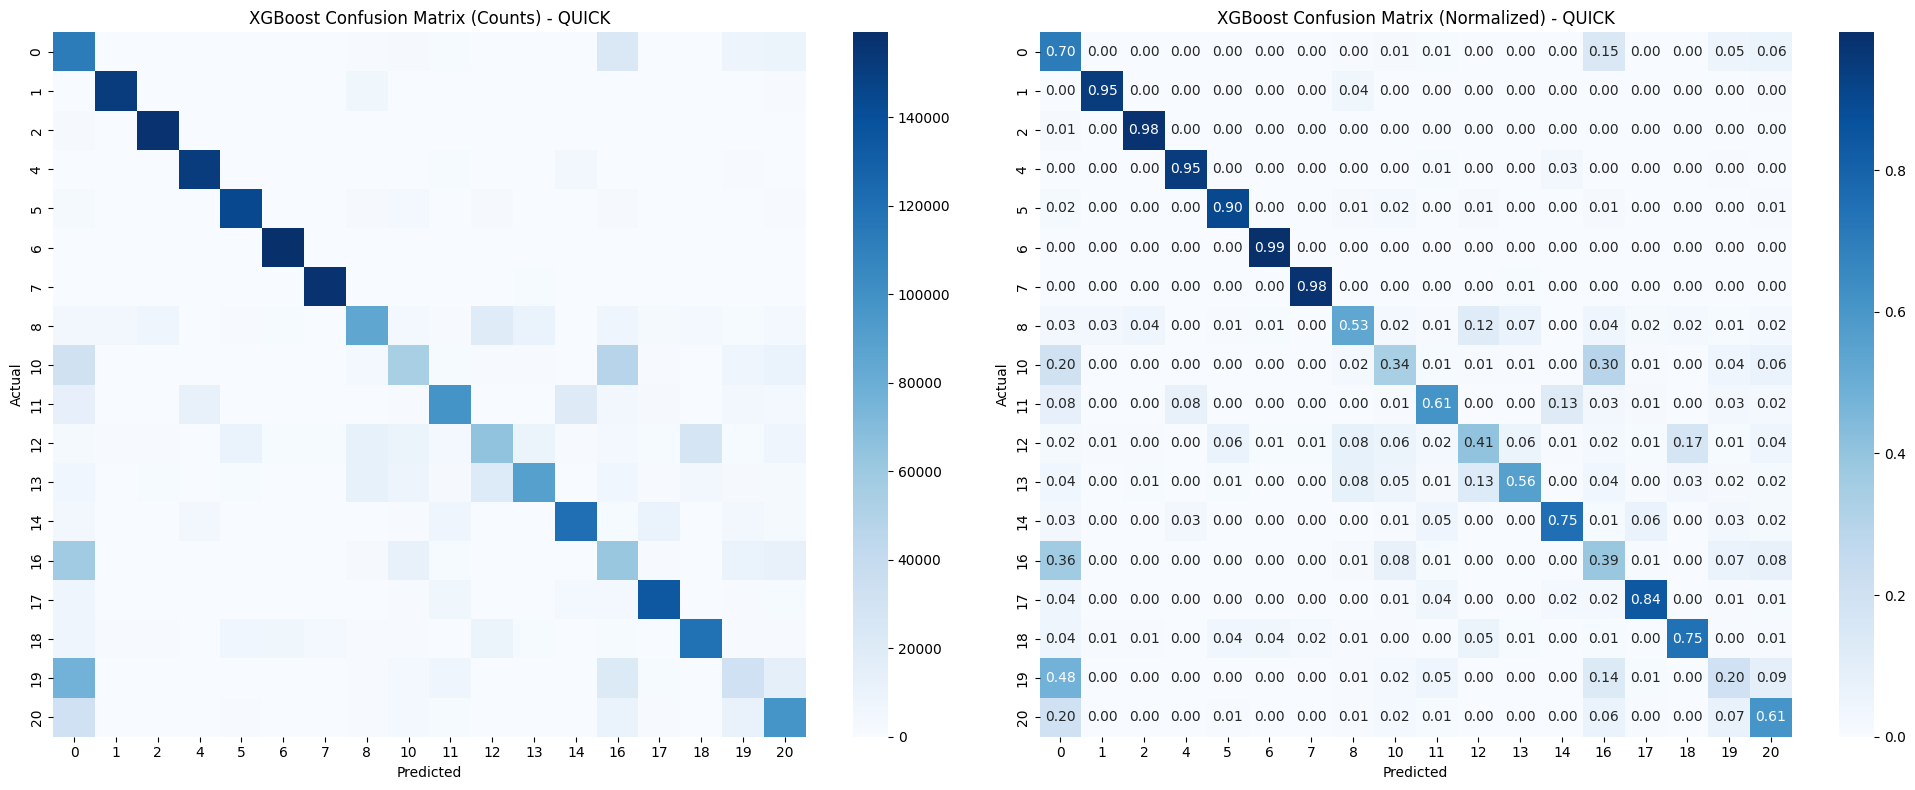

✓ Saved confusion matrix to ../outputs/figures/xgboost_confusion_matrix_quick.png


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'XGBoost Confusion Matrix (Counts){" - QUICK" if QUICK_MODE else ""}')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'XGBoost Confusion Matrix (Normalized){" - QUICK" if QUICK_MODE else ""}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved confusion matrix to {FIGURES_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.png'}")

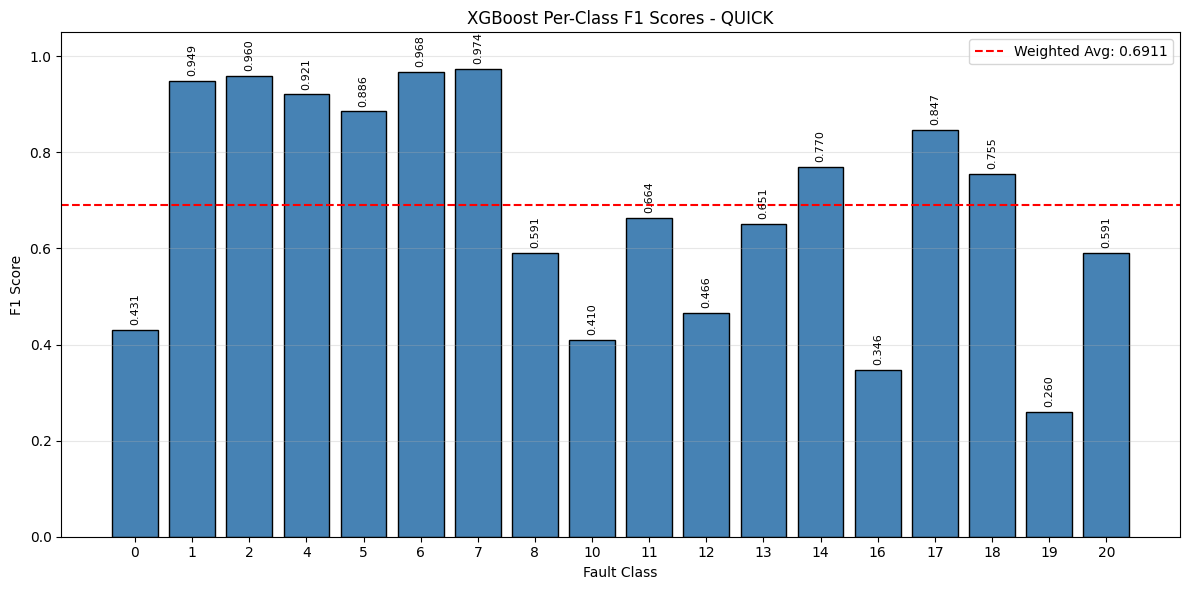

In [9]:
# Per-class F1 scores
f1_per_class = f1_score(y_test, y_pred, average=None)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, f1_per_class, color='steelblue', edgecolor='black')
ax.axhline(y=f1_weighted, color='red', linestyle='--', label=f'Weighted Avg: {f1_weighted:.4f}')
ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title(f'XGBoost Per-Class F1 Scores{" - QUICK" if QUICK_MODE else ""}')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, f1 in zip(bars, f1_per_class):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{f1:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_per_class_f1{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

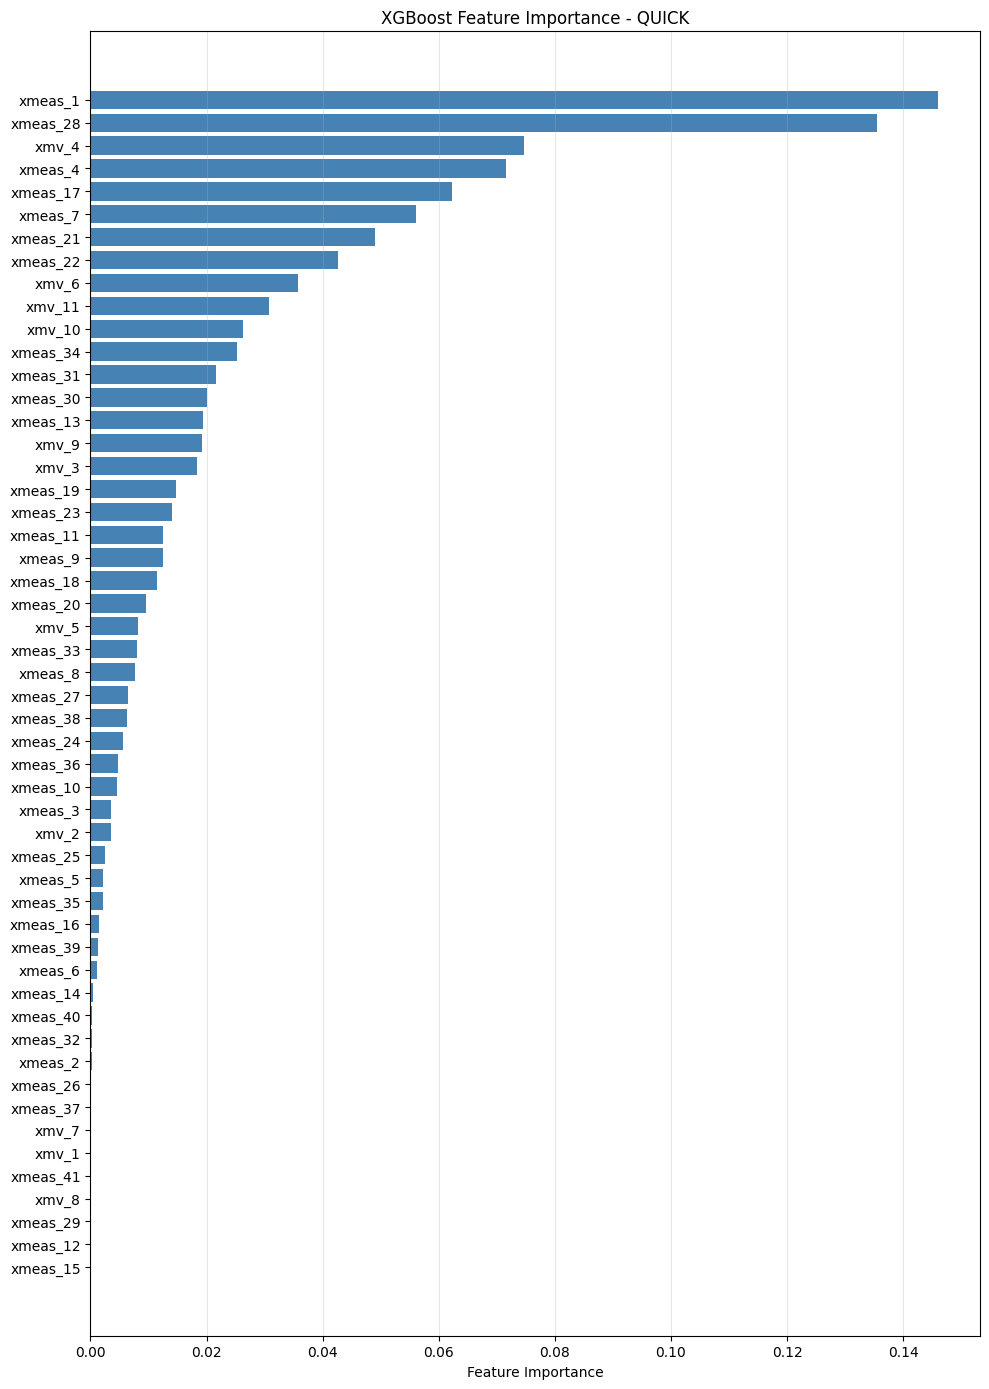


Top 10 Most Important Features:
  xmeas_1: 0.1459
  xmeas_28: 0.1355
  xmv_4: 0.0748
  xmeas_4: 0.0716
  xmeas_17: 0.0623
  xmeas_7: 0.0560
  xmeas_21: 0.0490
  xmeas_22: 0.0427
  xmv_6: 0.0358
  xmv_11: 0.0307


In [10]:
# Feature importance
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 14))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance{" - QUICK" if QUICK_MODE else ""}')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'xgboost_feature_importance{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

# Top 10 features
print("\nTop 10 Most Important Features:")
for i, row in importance_df.tail(10).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Save Results

In [11]:
end_time = time.time()
total_runtime = end_time - start_time

# Compile all metrics
metrics = {
    'model': 'XGBoost',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'train_fraction': TRAIN_FRACTION,
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'best_iteration': best_iteration,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'hyperparameters': best_params,
    'training_time_seconds': float(train_time),
    'total_runtime_seconds': float(total_runtime),
    'random_seed': RANDOM_SEED
}

# Save metrics
with open(METRICS_DIR / f'xgboost_metrics{MODE_SUFFIX}.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics to {METRICS_DIR / f'xgboost_metrics{MODE_SUFFIX}.json'}")

# Save model
with open(MODEL_DIR / f'xgboost_final{MODE_SUFFIX}.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'features': features
    }, f)
print(f"✓ Saved model to {MODEL_DIR / f'xgboost_final{MODE_SUFFIX}.pkl'}")

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(METRICS_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.csv')
print(f"✓ Saved confusion matrix to {METRICS_DIR / f'xgboost_confusion_matrix{MODE_SUFFIX}.csv'}")

print(f"\n{'='*60}")
print(f"✓ XGBoost Final Training Complete! {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
print(f"Total runtime: {int(total_runtime // 60)}m {int(total_runtime % 60)}s")
print(f"Best iteration: {best_iteration}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 (weighted): {f1_weighted:.4f}")
print(f"{'='*60}")

✓ Saved metrics to ../outputs/metrics/xgboost_metrics_quick.json
✓ Saved model to ../outputs/models/xgboost_final_quick.pkl
✓ Saved confusion matrix to ../outputs/metrics/xgboost_confusion_matrix_quick.csv

✓ XGBoost Final Training Complete! (QUICK MODE)
Total runtime: 0m 28s
Best iteration: 0
Test Accuracy: 0.6913
Test F1 (weighted): 0.6911
